In [1]:
%matplotlib inline
import data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
idd, seq = data.readseq('train.csv')

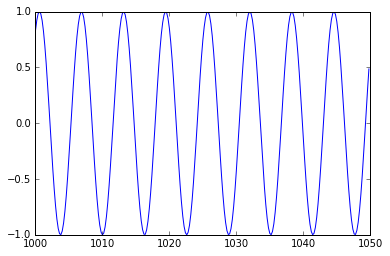

In [22]:
x = np.arange(1000, 1050, step=0.2)
y = np.sin(x)
plt.plot(x, y)
plt.show()

In [74]:
seq = [x for x in seq if max(x)<7372235460687]

In [4]:
def get_batch(s, ix):
    t = s[ix]
    return t[:-1], t[1:]
def sine_data(ix,size=50):
    x = np.arange(ix, ix + size, step = 0.2)
    y = np.sin(x)
    return y[:-1], y[1:]

In [83]:
inp_out_size = 1
hidden_layer_size = 20
lr = 0.001
epoch = 10000
print_step = 500
num_steps = 15

In [59]:
# zoneout as in https://arxiv.org/pdf/1606.01305v1.pdf
def zoneout(h, h_prev):
    assert h.get_shape() == h_prev.get_shape()
    r = tf.select(tf.random_uniform(h.get_shape()) > keep, tf.ones_like(h), tf.zeros_like(h))
    h_z = tf.mul(r, h_prev) + tf.mul(tf.sub(tf.ones_like(r), r), h)
    return h_z

In [60]:
tf.reset_default_graph()
initializer = tf.random_uniform_initializer(minval=-0.01, maxval=0.01, dtype=tf.float32)
Wxh = tf.get_variable('Wxh', shape=[inp_out_size, hidden_layer_size], initializer=initializer)
Whh = tf.get_variable('Whh', shape=[hidden_layer_size, hidden_layer_size], initializer=initializer)
Why = tf.get_variable('Why',shape=[hidden_layer_size, inp_out_size], initializer=initializer)
# weights associated with update gate
Wxz = tf.get_variable('Wxz', shape=[inp_out_size, hidden_layer_size], initializer=initializer)
Whz = tf.get_variable('Whz', shape=[hidden_layer_size, hidden_layer_size], initializer=initializer)
# weights associated with the reset gate
Wxr = tf.get_variable('Wxr', shape=[inp_out_size, hidden_layer_size], initializer=initializer)
Whr = tf.get_variable('Whr', shape=[hidden_layer_size, hidden_layer_size], initializer=initializer)

In [61]:
def GRU(prev, inp):
    i = tf.reshape(inp, shape=[1, -1])
    p = tf.reshape(prev, shape=[1, -1])
    z = tf.nn.sigmoid(tf.matmul(i, Wxz) + tf.matmul(p, Whz))    # update gate
    r = tf.nn.sigmoid(tf.matmul(i, Wxr) + tf.matmul(p, Whr))    # reset gate
    h_ = tf.nn.tanh(tf.matmul(i, Wxh) + tf.matmul(tf.mul(p, r), Whh))
    h = tf.mul(tf.sub(tf.ones_like(z), z), h_) + tf.mul(z, p)
#     h = zoneout(h, p)
    return tf.reshape(h, [hidden_layer_size])

In [62]:
# model
inputs = tf.placeholder(shape=[None, 1], dtype=tf.float32)
targets = tf.placeholder(shape=[None, 1], dtype=tf.float32)
keep = tf.placeholder(dtype=tf.float32)
initial = tf.placeholder(shape=[hidden_layer_size], dtype=tf.float32)
hiddens = tf.scan(GRU, inputs, initializer=initial)
outputs = tf.matmul(hiddens, Why)
loss = tf.sqrt(tf.reduce_sum(tf.square(tf.sub(outputs, targets))))
optimizer = tf.train.GradientDescentOptimizer(lr)
optimize_op = optimizer.minimize(loss)

In [84]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [85]:
ix = 1
ini = np.zeros([hidden_layer_size])

In [89]:
for i in range(epoch):
#     a, b = sine_data(ix, size=num_steps)    
    a, b = get_batch(seq, ix)
    a = np.reshape(a, [-1, 1])
    b = np.reshape(b, [-1, 1])
    if ix == len(idd):
        ix = 0
    l, h, _ = sess.run([loss, hiddens, optimize_op], {inputs: a, targets: b, initial: ini, keep: 0.7})
    ix += 1
    if i % print_step == 0:
        print('Loss', l)
    ix += 1
#     ini = h[-1]
    ini = np.zeros([hidden_layer_size])

Loss nan


KeyboardInterrupt: 

In [38]:
def generate(sess, n):
    ix = [[0.2]]
    v = []
    h = np.zeros(hidden_layer_size)
    for i in range(n):
        o, h = sess.run([outputs, hiddens], {inputs:ix, initial: h, keep: 1.0})
        h = h.reshape(hidden_layer_size)
        ix = o
        v.append(np.squeeze(o))
    return v

In [37]:
x = np.arange(0.2, 45, step = 0.2)
pred = np.array(generate(sess, len(x)))
true = np.sin(x)
print(x.shape, y.shape)
plt.plot(x, pred, 'b-')
plt.plot(x, true, 'r-')
plt.show()

NameError: name 'y' is not defined